### DistilBERT for Consumer Complaint Classification

**By: Omkar Kharkar**

### Introduction

Customer complaint classification and routing is an important task for banks and insurance companies. This task invovles classifying complaint text data received from customers into one of several lines of business to ensure that the correct line of business is forwarded the request.

This notebook contains my Python code, images and interactive elements for classifying customer complaints into the appropriate service category. The dataset was obtained from the CFPB website and the CSV file can be downloaded here:

https://www.consumerfinance.gov/data-research/consumer-complaints/#download-the-data

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
os.chdir("D:/Datasets")
os.environ['TRANSFORMERS_CACHE'] = 'D:/huggingface/transformers'
os.environ['HF_DATASETS_CACHE'] = 'D:/huggingface/datasets'
os.environ['HF_METRICS_CACHE'] = 'D:/huggingface/metrics'
os.environ['HF_MODULE_CACHE'] = 'D:/huggingface/modules'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import cuda
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import LabelEncoder

import wandb
import time
from rouge_score import rouge_scorer
import shap
import scipy as sp
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from matplotlib import pyplot as plt

from datasets import load_dataset, Dataset, load_metric
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertModel, DistilBertConfig
from transformers import AdamW, get_scheduler
from tqdm.auto import tqdm

!python --version
print('\n')
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)

!nvidia-smi

Python 3.8.8


Numpy version:  1.20.2
Pandas version:  1.2.3
Wed Jun 16 19:42:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.89       Driver Version: 465.89       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 36%   53C    P8    15W / 250W |   1532MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                           

In [2]:
raw_data = pd.read_csv("D:/OneDrive_Omkar/OneDrive/Machine Learning/NLP_Customer_Complaints/complaints_raw.csv").head(20000)

raw_data_essentials = raw_data[["Complaint ID", "Product", "Consumer complaint narrative"]]
raw_data_essentials_2 = raw_data_essentials.rename(columns={"Product":"product_group", 
                                                            'Consumer complaint narrative':'text', 
                                                            "Complaint ID":"Complaint_ID"})
raw_data_essentials_2.columns
raw_data_essentials_3 = raw_data_essentials_2.dropna(inplace=False)

raw_data_essentials_3.loc[raw_data_essentials_3['product_group'] == 'Credit reporting, credit repair services, or other personal consumer reports', 'product_group'] = 'Credit reporting'
raw_data_essentials_3.loc[raw_data_essentials_3['product_group'] == 'Credit card', 'product_group'] = 'Credit card or prepaid card'
raw_data_essentials_3.loc[raw_data_essentials_3['product_group'] == 'Prepaid card', 'product_group'] = 'Credit card or prepaid card'
raw_data_essentials_3.loc[raw_data_essentials_3['product_group'] == 'Payday loan', 'product_group'] = 'Payday loan, title loan, or personal loan'
raw_data_essentials_3.loc[raw_data_essentials_3['product_group'] == 'Virtual currency', 'product_group'] = 'Money transfer, virtual currency, or money service'
raw_data_essentials_3.loc[raw_data_essentials_3['product_group'] == 'Money transfers', 'product_group'] = 'Money transfer, virtual currency, or money service'
raw_data_essentials_3 = raw_data_essentials_3[raw_data_essentials_3.product_group != 'Other financial service']

raw_data_essentials_3['product_group'].value_counts()

raw_data_essentials_3.head(10)
raw_data_essentials_3.shape

Index(['Complaint_ID', 'product_group', 'text'], dtype='object')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Credit reporting                                      2050
Debt collection                                        882
Credit card or prepaid card                            451
Mortgage                                               399
Checking or savings account                            288
Student loan                                           167
Vehicle loan or lease                                  107
Payday loan, title loan, or personal loan               95
Money transfer, virtual currency, or money service      88
Consumer Loan                                            5
Name: product_group, dtype: int64

,Complaint_ID,product_group,text
0,3384392,Debt collection,transworld systems inc. \nis trying to collect...
2,3417821,Credit reporting,I would like to request the suppression of the...
3,3433198,Debt collection,"Over the past 2 weeks, I have been receiving e..."
11,3366475,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh..."
12,3385399,Debt collection,While checking my credit report I noticed thre...
14,3446975,Credit reporting,Today XX/XX/XXXX went online to dispute the in...
16,3214857,Credit reporting,XXXX is reporting incorrectly to Equifax and X...
17,3417374,Credit reporting,Please reverse the late payments reported on t...
18,3444592,Credit reporting,I would like the credit bureau to correct my X...
19,3379924,Credit reporting,MY NAME IS XXXX XXXX XXXX I live at XXXX XXXX ...


(4532, 3)

### Cleaning the Data / Exploratory Analysis

Before we focus on classification, let's focus on doing some initial text cleaning and exploration to understand the transcription data better.

Steps:
- Remove stray characters (except periods, commas and percent signs)
- Periods, Commas, Percent signs should only be removed at the end of sentences or stray characters. We do NOT want to remove them from numbers, as this would change the magnitude of the numbers themselves.
- Stop words (the, not, with, etc.) will be left in, as this can completely change the meaning of the text:<br>

**Example:**<br>
'The aortic valve appears calcified **with** mild aortic valve stenosis' <br>

- Further discussion is requried to decide which words to remove, and further cleaning that should be done.

In [3]:
for i in range(0, 10):
    print(raw_data_essentials_3['text'].iloc[i])

transworld systems inc. 
is trying to collect a debt that is not mine, not owed and is inaccurate.
I would like to request the suppression of the following items from my credit report, which are the result of my falling victim to identity theft. This information does not relate to [ transactions that I have made/accounts that I have opened ], as the attached supporting documentation can attest. As such, it should be blocked from appearing on my credit report pursuant to section 605B of the Fair Credit Reporting Act.
Over the past 2 weeks, I have been receiving excessive amounts of telephone calls from the company listed in this complaint. The calls occur between XXXX XXXX and XXXX XXXX to my cell and at my job. The company does not have the right to harass me at work and I want this to stop. It is extremely distracting to be told 5 times a day that I have a call from this collection agency while at work.
I was sold access to an event digitally, of which I have all the screenshots to de

In [4]:
def remove_x(test_string):
    new_string = re.sub(r'[X]+\/[X]+\/\d+|[X]+', "", test_string)
    return new_string

def clean_text(test_string):
    new_string = re.sub(r'(?<!\d)[.,;:%$[]](?!\d)',"", test_string)
    new_string_2 = new_string.replace('\n', '')
    return new_string_2

def complaint_length_histogram(clean_data, field):
    clean_data[field].hist(bins=30, figsize=(10,10))
    plt.xlabel("Number of Words Per Complaint", fontsize=12)
    plt.ylabel("Frequency",fontsize=12)
    return

In [5]:
clean_data = raw_data_essentials_3.copy(deep=True)
clean_data['text'] = raw_data_essentials_3['text'].apply(remove_x)
clean_data['text'] = clean_data['text'].apply(clean_text)
clean_data['text_count'] = clean_data['text'].str.split().str.len()

# Keep only text that is greater than 15 - 1000 words max, to filter out excessively long complaints
clean_data = clean_data[(clean_data['text_count'] >= 15) & (clean_data['text_count'] <= 1000)]
clean_data.head(10)

,Complaint_ID,product_group,text,text_count
0,3384392,Debt collection,transworld systems inc. is trying to collect a...,18
2,3417821,Credit reporting,I would like to request the suppression of the...,72
3,3433198,Debt collection,"Over the past 2 weeks, I have been receiving e...",74
11,3366475,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh...",68
12,3385399,Debt collection,While checking my credit report I noticed thre...,217
14,3446975,Credit reporting,Today // went online to dispute the incorrect ...,20
16,3214857,Credit reporting,is reporting incorrectly to Equifax and an a...,65
17,3417374,Credit reporting,Please reverse the late payments reported on t...,38
19,3379924,Credit reporting,MY NAME IS I live at SC My DOB my SS...,68
20,3420108,Credit reporting,ALL THREE CREDIT BUREAUS ARE STILL PUTTING FRA...,155


<Figure size 720x720 with 0 Axes>

<AxesSubplot:xlabel='count', ylabel='product_group'>

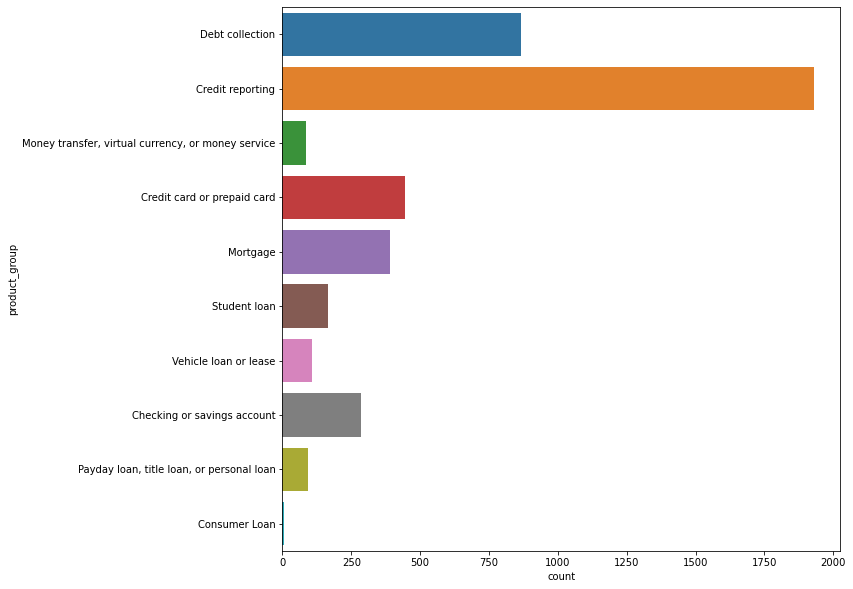

In [6]:
plt.figure(figsize=(10,10))
sns.countplot(y='product_group', data = clean_data)
plt.show()

<AxesSubplot:>

count    4372.000000
mean      185.297804
std       150.982535
min        15.000000
25%        75.000000
50%       142.000000
75%       249.000000
max       985.000000
Name: text_count, dtype: float64

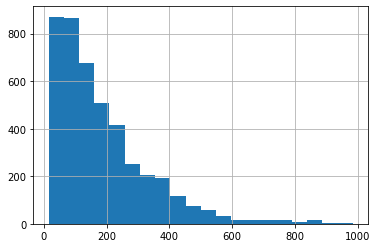

In [7]:
clean_data['text_count'].hist(bins=20)
clean_data['text_count'].describe()

In [8]:
le = LabelEncoder()
text_labels = le.fit_transform(clean_data['product_group'])
text_labels[0:20]
clean_data['product_group'] = le.fit_transform(clean_data['product_group'])
clean_data = pd.DataFrame(clean_data.loc[:, ['product_group', 'text']])
clean_data

array([4, 3, 4, 5, 4, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 6, 3, 3, 3])

,product_group,text
0,4,transworld systems inc. is trying to collect a...
2,3,I would like to request the suppression of the...
3,4,"Over the past 2 weeks, I have been receiving e..."
11,5,"I was sold access to an event digitally, of wh..."
12,4,While checking my credit report I noticed thre...
...,...,...
19986,4,- sent letter as to verify debt and provide p...
19990,6,I am reaching out to Consumer Financial Protec...
19991,3,I request to update my account to correctly ...
19996,3,I have been the victim of identity theft and t...


### Word Clouds

We analyze the most frequent words using the concept of Term Frequency-Inverse Document Frequency, which surfaces words based on their appearance in one document, as well as across documents.

A sample of documents here, given the computational overhead of running TF-IDF on this script.

00                     20.854810
00 00                   0.129322
00 10                   0.085319
00 100                  0.070895
00 1000                 0.152386
                         ...    
zero responsibility     0.049510
zeroed                  0.081556
zeroed card             0.081556
zip                     0.082392
zip code                0.082392
Length: 61472, dtype: float64

Time Taken for Text List of Length  1000 : 12.7


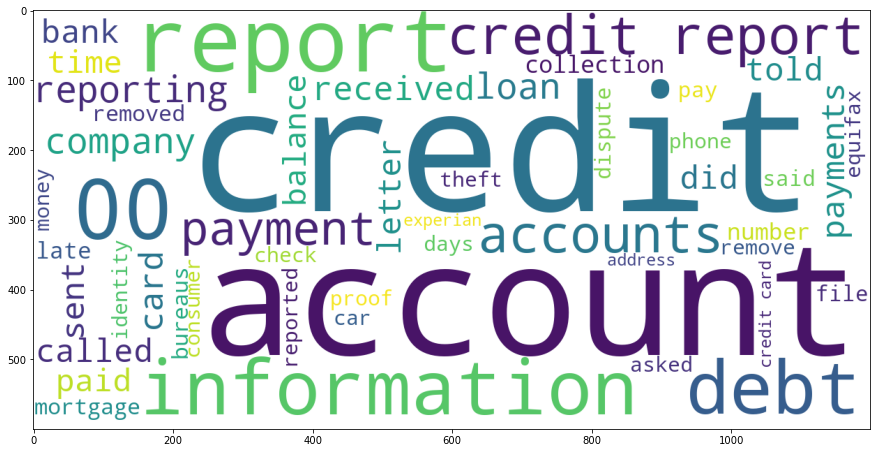

In [9]:
texts = clean_data['text'].tolist()[0:1000]
def get_word_cloud(corpus, ngrams=(1,2)):
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=ngrams)
    vecs = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names()
    dense = vecs.todense()
    lst1 = dense.tolist()
    df = pd.DataFrame(lst1, columns=feature_names)
    display(df.T.sum(axis=1))
    Cloud = WordCloud(background_color="white", max_words=50,
                      width=1200, height=600).generate_from_frequencies(df.T.sum(axis=1))
    plt.figure(figsize=(15,10))
    display(plt.imshow(Cloud))
    return df

t0 = time.time()
tfidf_1 = get_word_cloud(texts)
print("Time Taken for Text List of Length ", len(texts), ":", round(time.time() - t0, 2))

In [10]:
tfidf_1_list = pd.DataFrame(tfidf_1.T.sum(axis=1), columns=['TFIDF_Score']).sort_values(by=['TFIDF_Score'], ascending=False)
tfidf_1_list.head(10)
tfidf_1_list.reset_index(level=0, inplace=True)
freq_word_list = tfidf_1_list['index'].tolist()[0:10]

,TFIDF_Score
credit,38.085390
account,30.582744
report,23.297989
00,20.854810
information,19.620536
debt,18.527991
credit report,17.379211
accounts,16.589931
payment,16.227929
reporting,16.051508


### DistilBERT for Text Classification

The following steps are used to train the dataset. This is for demonstration purposes, only.<br>

Model Performance:
{'accuracy': 0.49586776859504134}

In [11]:
clean_data
clean_data.columns

,product_group,text
0,4,transworld systems inc. is trying to collect a...
2,3,I would like to request the suppression of the...
3,4,"Over the past 2 weeks, I have been receiving e..."
11,5,"I was sold access to an event digitally, of wh..."
12,4,While checking my credit report I noticed thre...
...,...,...
19986,4,- sent letter as to verify debt and provide p...
19990,6,I am reaching out to Consumer Financial Protec...
19991,3,I request to update my account to correctly ...
19996,3,I have been the victim of identity theft and t...


Index(['product_group', 'text'], dtype='object')

In [12]:
comp_dataset = Dataset.from_pandas(clean_data).train_test_split(test_size=0.2)
comp_dataset

DatasetDict({
    train: Dataset({
        features: ['product_group', 'text', '__index_level_0__'],
        num_rows: 3497
    })
    test: Dataset({
        features: ['product_group', 'text', '__index_level_0__'],
        num_rows: 875
    })
})

In [ ]:
# Set some of the parameters here:
num_cats = len(clean_data['product_group'].unique())

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

tokenized_datasets = comp_dataset.map(tokenize_function, batched=True)

# Remove columns and the original text column for processing
tokenized_datasets = tokenized_datasets.remove_columns(["text", '__index_level_0__'])
tokenized_datasets = tokenized_datasets.rename_column("product_group", "labels")
tokenized_datasets.set_format("torch")

small_train_dataset = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["test"]

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

myconfig = DistilBertConfig.from_pretrained('distilbert-base-uncased', num_labels=num_cats)
model = DistilBertForSequenceClassification(config=myconfig)

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

model.to(device)

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

metric = load_metric("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.7245714285714285}

### SHAP Value Calculations

SHAP Values can be used to explain why a particular observation received a prediction, and what words contributed to that text's prediction. Additionally, they can be used to understand what instance of a particular word was important in which context.

Partition explainer:  49%|█████████████████████████████▍                              | 49/100 [00:38<00:36,  1.42it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (647 > 512). Running this sequence through the model will result in indexing errors
Partition explainer: 101it [01:17,  1.17it/s]                                                                          
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


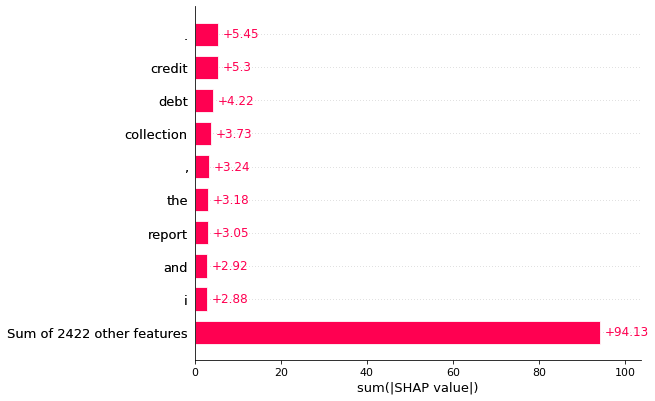

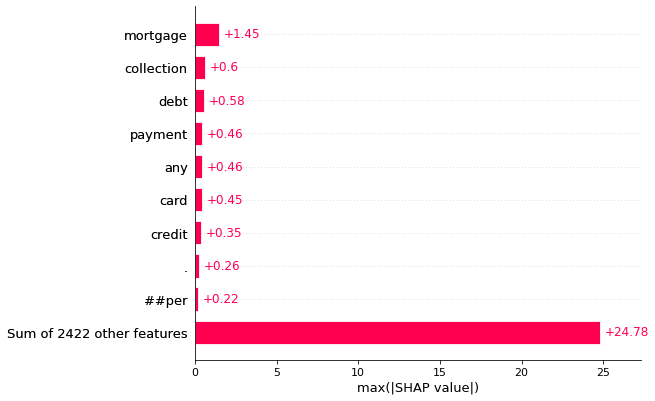

In [14]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=500, truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

explainer = shap.Explainer(f, tokenizer)
shap_values = explainer(comp_dataset['train']['text'][0:100], fixed_context=1)
shap.plots.text(shap_values[:5])
shap.plots.bar(shap_values.abs.sum(0))
shap.plots.bar(shap_values.abs.max(0))

#### Impact of Most Frequent Words

The SHAP bar plot shows, for the most common TF-IDF words identified above, the most impactful contribution of each word to the prediction.

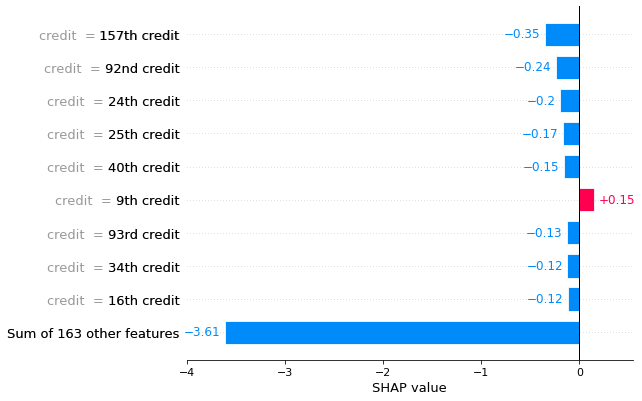

None

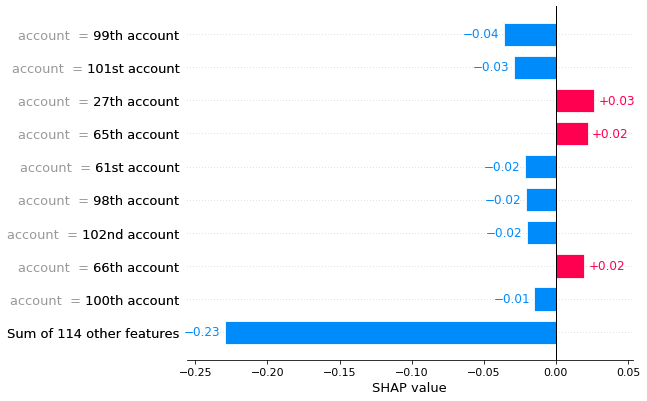

None

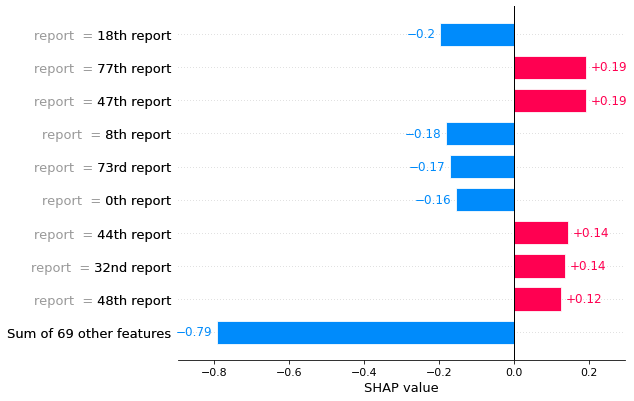

None

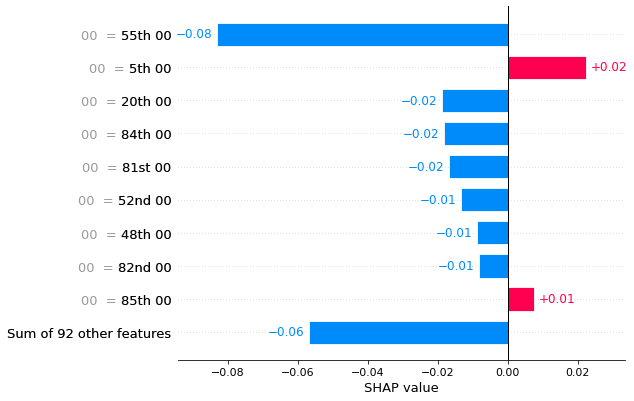

None

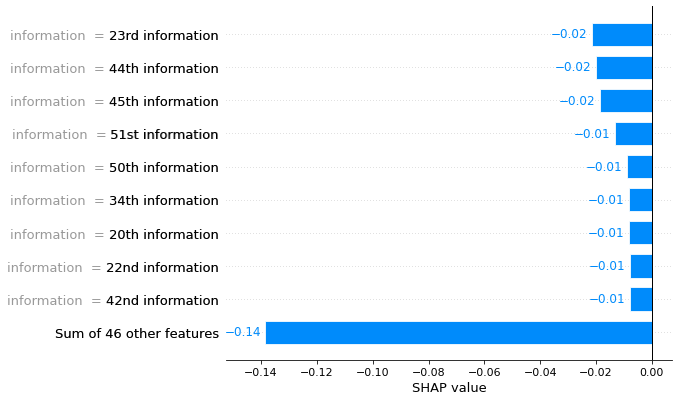

None

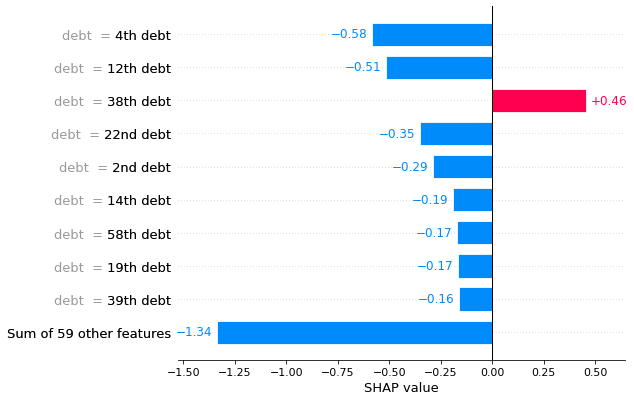

None

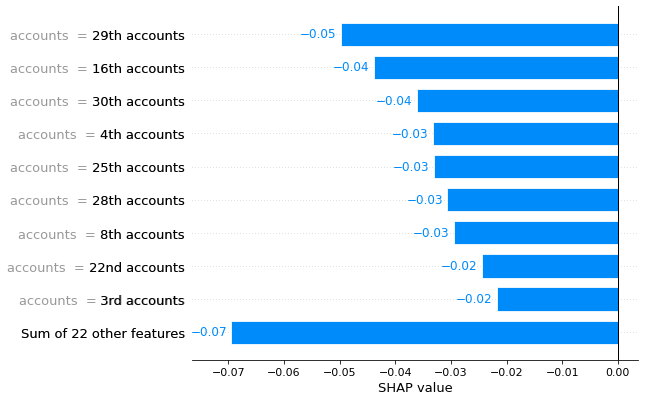

None

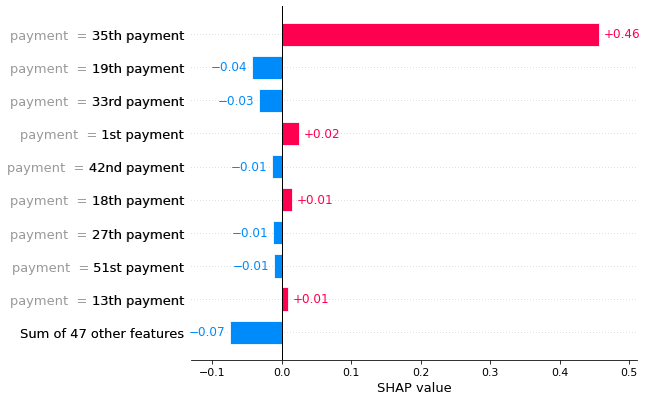

None

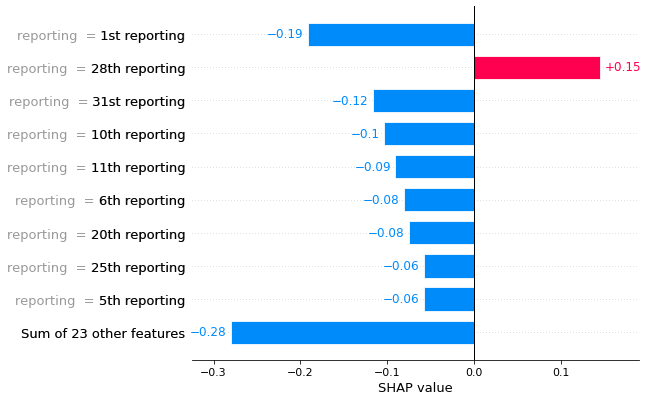

None

In [15]:
def get_word_shap(word_list):
    for word in word_list:
        try:
            display(shap.plots.bar(shap_values[:, word]))
        except:
            continue
    return

get_word_shap(freq_word_list)